In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Import csv file 
data = pd.read_csv("../../housing.csv")

In [3]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [10]:
# inspect the first 5 rows of the dataset
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## First GLM model

In [40]:
df = pd.read_csv("../../housing.csv")

### Cleaning data

In [41]:
#drop similar variables

cols_to_drop = ["Id", "Exterior2nd", "Alley", "MasVnrType", "MasVnrArea", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "MiscFeature", "BsmtFinSF2", "BsmtUnfSF", "GarageCars", "GarageCond", "3SsnPorch", "WoodDeckSF", "ScreenPorch", "PoolQC", "MiscFeature", "Condition2", "BsmtQual", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "HalfBath", "ScreenPorch", "PoolQC", "LotShape", "GarageYrBlt", "FireplaceQu", "GarageFinish"]
df = df.drop(columns=cols_to_drop)

In [42]:
# Treat missing numeric data

# Select numeric columns
num_cols = df.select_dtypes(include=['number']).columns

# Show only numeric columns that have missing values
num_missing = df[num_cols].isna().sum()
num_missing = num_missing[num_missing > 0]  # filter only those with NA
print(num_missing)

LotFrontage    259
dtype: int64


In [43]:
df['LotFrontage'] = df['LotFrontage'].fillna(0)
num_missing = df[num_cols].isna().sum()
num_missing = num_missing[num_missing > 0]  # filter only those with NA
print(num_missing)

Series([], dtype: int64)


In [44]:
# Select categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

# Show only categorical columns that have missing values
cat_missing = df[cat_cols].isna().sum()
cat_missing = cat_missing[cat_missing > 0]
print(cat_missing)

BsmtCond        37
Electrical       1
GarageType      81
GarageQual      81
Fence         1179
dtype: int64


In [45]:
df['BsmtCond'] = df['BsmtCond'].fillna("NoBasement")
df['Electrical'] = df['Electrical'].fillna("NoElectricity")
df['GarageType'] = df['GarageType'].fillna("NoGarage")
df['GarageQual'] = df['GarageQual'].fillna("NoGarage")
df['Fence'] = df['Fence'].fillna("NoFence")
cat_missing = df[cat_cols].isna().sum()
cat_missing = cat_missing[cat_missing > 0]
print(cat_missing)

Series([], dtype: int64)


### Preprocessing and checking assumptions

In [46]:
# Split features and target

from sklearn.model_selection import train_test_split

X = df.drop(columns='SalePrice')
y = df['SalePrice']

# Split into train/test sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Reset indices

X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

In [47]:
# divide into numeric and categoric
num_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

Exploration of numeric parameters

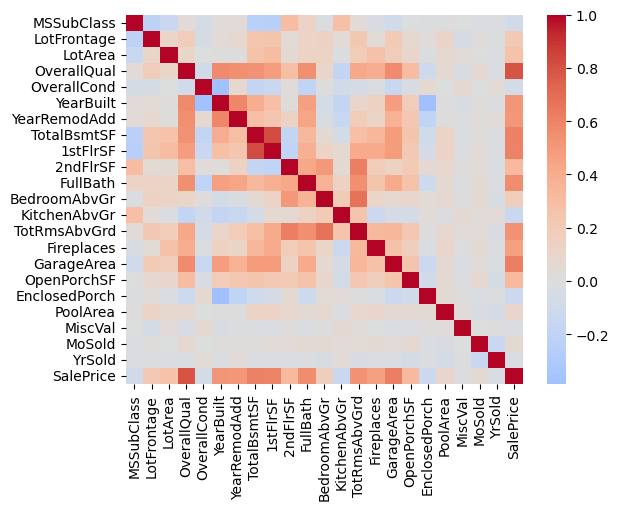

In [48]:
# Exploration of numeric with a correlation heatmap

corr = df[num_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.show()

In [49]:
# Drop multicollinear numeric columns

drop_cols = ["YearRemodAdd", "YrSold", "KitchenAbvGr", "BedroomAbvGr", "FullBath", "2ndFlrSF", "TotalBsmtSF", "MiscVal", "LotFrontage", "MoSold", "MSSubClass", "OverallQual", "OverallCond", "TotRmsAbvGrd", "Fireplaces", "PoolArea"]

X_train = X_train.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)
num_cols = [col for col in num_cols if col in X_train.columns]

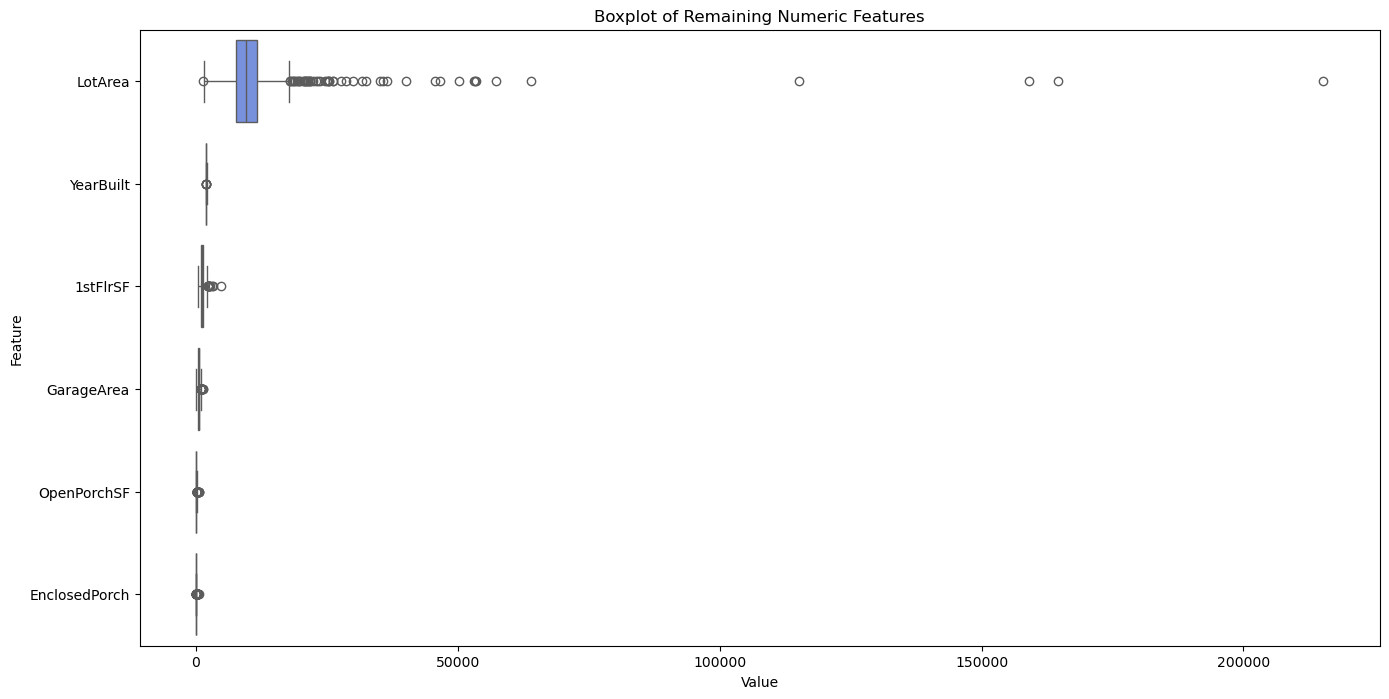

In [55]:
# Plot remaining numeric columns

plt.figure(figsize=(16, 8))
sns.boxplot(data=X_train[num_cols], orient="h", palette="coolwarm")
plt.title("Boxplot of Remaining Numeric Features")
plt.xlabel("Value")
plt.ylabel("Feature")
plt.show()

Exploration of categoric variables

In [50]:
# Exploration of categoric with chi square

from scipy.stats import chi2_contingency

for col in cat_cols:
    table = pd.crosstab(X_train[col], y_train)
    chi2, p, _, _ = chi2_contingency(table)
    print(col, p)

MSZoning 5.023726671844421e-06
Street 0.00010125861245201854
LandContour 0.028195040777228026
Utilities 0.9999999993044967
LotConfig 0.19162686863353698
LandSlope 0.00184796310393468
Neighborhood 1.2545832789146172e-09
Condition1 1.0
BldgType 0.9972013912592697
HouseStyle 0.5430828206005074
RoofStyle 0.9999999999999966
RoofMatl 1.0
Exterior1st 0.9999999999544007
ExterQual 1.6324107604827433e-17
ExterCond 4.919775330739174e-09
Foundation 0.00039555259198351513
BsmtCond 7.636458855662935e-29
Heating 1.083400322903062e-16
HeatingQC 0.9999073868748176
CentralAir 0.00020758048205255278
Electrical 0.9981478511611908
KitchenQual 1.3670538906250214e-21
Functional 1.0
GarageType 0.9763637619290917
GarageQual 0.5210808656921905
PavedDrive 0.9938246742281993
Fence 0.9999994333874076
SaleType 0.00026803644035070694
SaleCondition 8.378518083017518e-09


In [51]:
# Drop parameters with p>0.05

# Set significance threshold
alpha = 0.05

# List to keep
cat_keep = []

for col in cat_cols:
    table = pd.crosstab(X_train[col], y_train)
    chi2, p, _, _ = chi2_contingency(table)
    if p < alpha:
        cat_keep.append(col)
    else:
        print(f"Dropping {col} (p={p:.4f})")

# Drop irrelevant categorical columns
drop_cols = [col for col in cat_cols if col not in cat_keep]

X_train = X_train.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)
cat_cols = [col for col in cat_cols if col in X_train.columns]

Dropping Utilities (p=1.0000)
Dropping LotConfig (p=0.1916)
Dropping Condition1 (p=1.0000)
Dropping BldgType (p=0.9972)
Dropping HouseStyle (p=0.5431)
Dropping RoofStyle (p=1.0000)
Dropping RoofMatl (p=1.0000)
Dropping Exterior1st (p=1.0000)
Dropping HeatingQC (p=0.9999)
Dropping Electrical (p=0.9981)
Dropping Functional (p=1.0000)
Dropping GarageType (p=0.9764)
Dropping GarageQual (p=0.5211)
Dropping PavedDrive (p=0.9938)
Dropping Fence (p=1.0000)


Check if categories are balanced

In [53]:
for col in cat_cols:
    counts = X_train[col].value_counts(normalize=True)  # proportions
    print(f"\nColumn: {col}")
    print(counts)


Column: MSZoning
MSZoning
RL         0.791096
RM         0.147260
FV         0.045377
RH         0.012842
C (all)    0.003425
Name: proportion, dtype: float64

Column: Street
Street
Pave    0.996575
Grvl    0.003425
Name: proportion, dtype: float64

Column: LandContour
LandContour
Lvl    0.906678
Bnk    0.041096
HLS    0.029966
Low    0.022260
Name: proportion, dtype: float64

Column: LandSlope
LandSlope
Gtl    0.948630
Mod    0.043664
Sev    0.007705
Name: proportion, dtype: float64

Column: Neighborhood
Neighborhood
NAmes      0.154966
CollgCr    0.098459
OldTown    0.077911
Edwards    0.074486
Somerst    0.059075
NWAmes     0.056507
Gilbert    0.055651
NridgHt    0.052226
Sawyer     0.049658
BrkSide    0.038527
Crawfor    0.037671
SawyerW    0.037671
Mitchel    0.034247
NoRidge    0.028253
Timber     0.023973
IDOTRR     0.022260
SWISU      0.017979
StoneBr    0.017123
ClearCr    0.016267
Blmngtn    0.012842
BrDale     0.011130
MeadowV    0.008562
Veenker    0.007705
NPkVill    0.00

In [54]:
# Drop cols with one category over 90%

drop_cols = ["Street", "BsmtCond", "LandContour", "LandSlope", "Heating", "CentralAir"]

X_train.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)
cat_cols = [col for col in cat_cols if col not in drop_cols]

for col in num_cols:
    unique_ratio = X_train[col].nunique() / X_train.shape[0]
    print(f"{col}: {unique_ratio:.2f} unique ratio")

LotArea: 0.76 unique ratio
YearBuilt: 0.10 unique ratio
1stFlrSF: 0.56 unique ratio
GarageArea: 0.34 unique ratio
OpenPorchSF: 0.16 unique ratio
EnclosedPorch: 0.08 unique ratio


In [59]:
# Encode categorical columns into dummies 
obj_cols = X_train.select_dtypes(include="object").columns

X_train = pd.get_dummies(X_train, columns=obj_cols, drop_first=True)
X_test  = pd.get_dummies(X_test,  columns=obj_cols, drop_first=True)

# Align train and test
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# Cast to float
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

y_train = y_train.astype(float)
y_test  = y_test.astype(float)

### Building GLM

In [60]:
# add intercept
X_train_glm = sm.add_constant(X_train)
X_test_glm  = sm.add_constant(X_test)

# fit GLM (Gaussian = linear regression)
glm_model = sm.GLM(
    y_train,
    X_train_glm,
    family=sm.families.Gaussian()
)

glm_results = glm_model.fit()
print(glm_results.summary())

# predictions
y_pred_train = glm_results.predict(X_train_glm)
y_pred_test  = glm_results.predict(X_test_glm)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1168
Model:                            GLM   Df Residuals:                     1105
Model Family:                Gaussian   Df Model:                           62
Link Function:               Identity   Scale:                      1.4200e+09
Method:                          IRLS   Log-Likelihood:                -13932.
Date:                Wed, 17 Dec 2025   Deviance:                   1.5691e+12
Time:                        13:18:59   Pearson chi2:                 1.57e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9614
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.272e+

In [ ]:
#drop categories with p>0.05 and refit GLM

# Get p-values
pvals = glm_results.pvalues

# Keep only significant variables (p <= 0.05)
significant_vars = pvals[pvals <= 0.05].index

# Drop insignificant columns from train and test
X_train_sig = X_train_glm[significant_vars]
X_test_sig  = X_test_glm[significant_vars]

# Refit GLM
glm_model_sig = sm.GLM(y_train, X_train_sig, family=sm.families.Gaussian())
glm_results_sig = glm_model_sig.fit()

print(glm_results_sig.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1168
Model:                            GLM   Df Residuals:                     1143
Model Family:                Gaussian   Df Model:                           24
Link Function:               Identity   Scale:                      1.9582e+09
Method:                          IRLS   Log-Likelihood:                -14140.
Date:                Wed, 17 Dec 2025   Deviance:                   2.2383e+12
Time:                        13:20:10   Pearson chi2:                 2.24e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8735
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
LotArea                  0.5953 

In [65]:
# Get AIC
print(glm_results_sig.aic)

28329.086845797352


In [62]:
# Estimate GLM performance

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions already done
y_pred_train = glm_results_sig.predict(X_train_sig)
y_pred_test  = glm_results_sig.predict(X_test_sig)

# Validation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R²:", r2)

Validation RMSE: 50154.49973443451
Validation MAE: 32462.06029375601
Validation R²: 0.6720512562745529


### Explore GLM performance and residuals

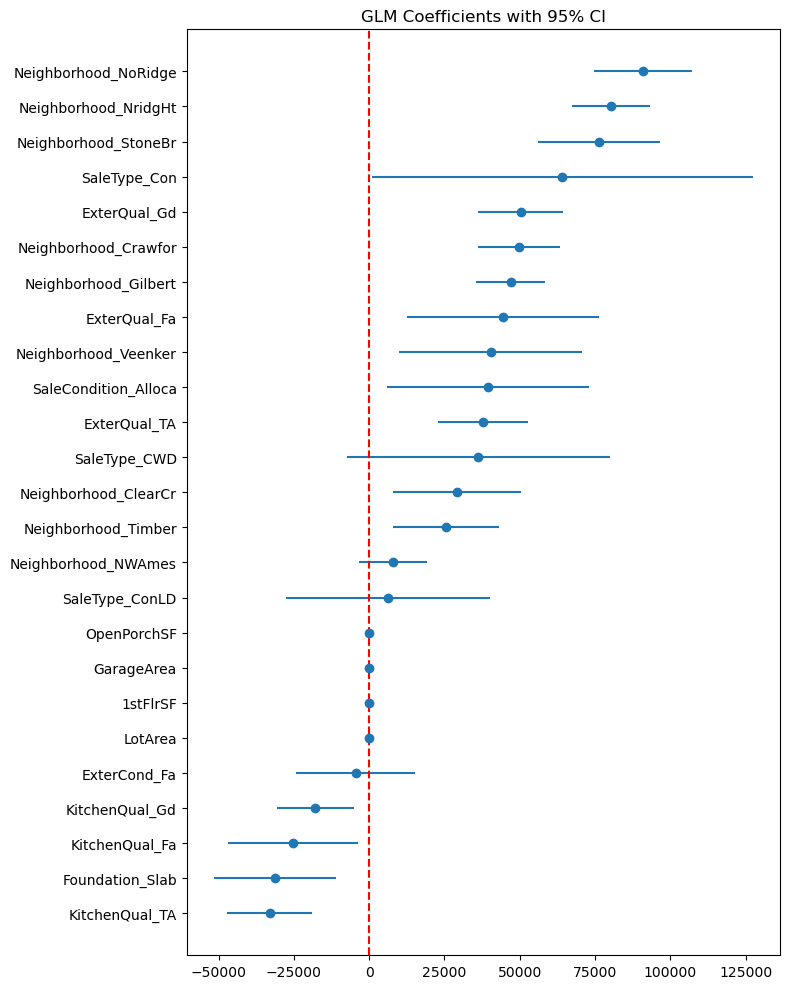

In [63]:
# Get coefficients and confidence intervals
coef = glm_results_sig.params
conf = glm_results_sig.conf_int()

# Combine into DataFrame
coef_df = pd.DataFrame({
    'coef': coef,
    'low': conf[0],
    'high': conf[1]
}).sort_values('coef')

# Plot
plt.figure(figsize=(8, 10))
plt.errorbar(
    coef_df['coef'], coef_df.index,
    xerr=[coef_df['coef'] - coef_df['low'],
          coef_df['high'] - coef_df['coef']],
    fmt='o'
)
plt.axvline(0, color='red', linestyle='--')  # zero line for reference
plt.title('GLM Coefficients with 95% CI')
plt.tight_layout()
plt.show()

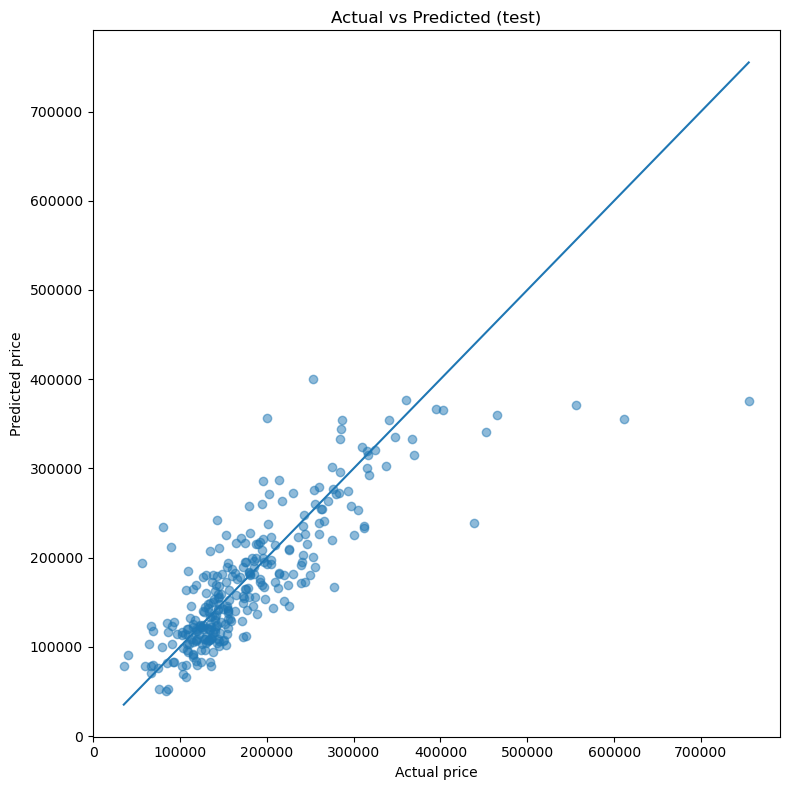

In [64]:
# Plot actial VS predicted SalePrice in the test set

plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Actual vs Predicted (test)")
plt.tight_layout()
plt.show()

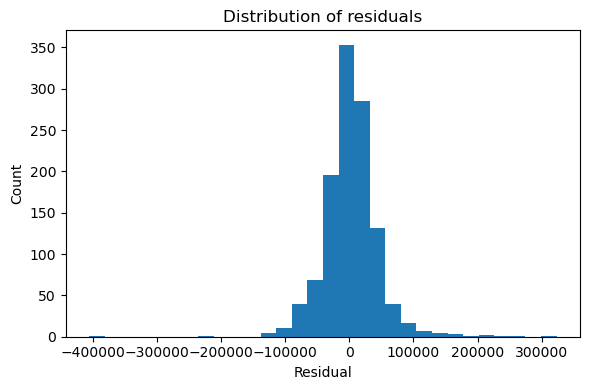

In [71]:
# Check distribution of residuals

residuals = glm_results_sig.resid_response

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Distribution of residuals")
plt.tight_layout()
plt.show()

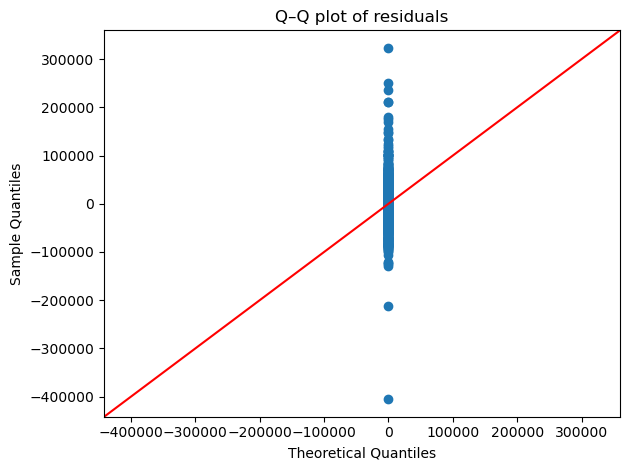

In [72]:
# Q - Q plot for residuals

import statsmodels.api as sm

sm.qqplot(residuals, line='45')
plt.title("Q–Q plot of residuals")
plt.tight_layout()
plt.show()

## Second GLM model (final)

Reduce the columns to seemingly relevant ones (using domain knowledge)

In [4]:
selected_columns = [
    'SalePrice', 'LotArea', 'Neighborhood', 'HouseStyle', 'YearBuilt', 
    'YearRemodAdd', 'Heating', 'CentralAir', 'TotRmsAbvGrd', 'FullBath', 
    'HalfBath', 'GrLivArea', 'GarageCars', 'PoolArea', 'OpenPorchSF'
]

reduced_df = data[selected_columns]


In [5]:
# Clean selected columns if necessary
#create df with selected columns only
df_selected_columns = data[selected_columns]

# Check for missing values
missing_values = df_selected_columns.isnull().sum()
print("Missing values in selected columns:\n", missing_values)

Missing values in selected columns:
 SalePrice       0
LotArea         0
Neighborhood    0
HouseStyle      0
YearBuilt       0
YearRemodAdd    0
Heating         0
CentralAir      0
TotRmsAbvGrd    0
FullBath        0
HalfBath        0
GrLivArea       0
GarageCars      0
PoolArea        0
OpenPorchSF     0
dtype: int64


In [6]:
# Create table
data = df_selected_columns.copy()

def format_example_values(series):
    vals = series.dropna().unique()[:5]
    
    formatted = []
    for v in vals:
        if isinstance(v, (int, float, np.number)):
            formatted.append(f"{v:.2f}")
        else:
            formatted.append(str(v))
    return ", ".join(formatted)

summary_df = pd.DataFrame({
    "Feature/variable": data.columns,
    "Data type": data.dtypes.values.astype(str),
    "Description": [""] * len(data.columns),
    "Number of Unique values": [data[col].nunique() for col in data.columns],
    "Example values": [format_example_values(data[col]) for col in data.columns]
})

# Show all rows without truncation
with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
    print(summary_df.to_markdown(index=False))


| Feature/variable   | Data type   | Description   |   Number of Unique values | Example values                                        |
|:-------------------|:------------|:--------------|--------------------------:|:------------------------------------------------------|
| SalePrice          | int64       |               |                       663 | 208500.00, 181500.00, 223500.00, 140000.00, 250000.00 |
| LotArea            | int64       |               |                      1073 | 8450.00, 9600.00, 11250.00, 9550.00, 14260.00         |
| Neighborhood       | object      |               |                        25 | CollgCr, Veenker, Crawfor, NoRidge, Mitchel           |
| HouseStyle         | object      |               |                         8 | 2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer                |
| YearBuilt          | int64       |               |                       112 | 2003.00, 1976.00, 2001.00, 1915.00, 2000.00           |
| YearRemodAdd       | int64       |     

In [7]:
# Check data types
print("\nData types of selected columns:\n", df_selected_columns.dtypes)


Data types of selected columns:
 SalePrice        int64
LotArea          int64
Neighborhood    object
HouseStyle      object
YearBuilt        int64
YearRemodAdd     int64
Heating         object
CentralAir      object
TotRmsAbvGrd     int64
FullBath         int64
HalfBath         int64
GrLivArea        int64
GarageCars       int64
PoolArea         int64
OpenPorchSF      int64
dtype: object


In [8]:
# Split into numeric and categorical columns
numeric_cols = reduced_df.select_dtypes(include=[np.number]).columns.tolist()
#drop taret variable from numeric cols
numeric_cols.remove('SalePrice')
categorical_cols = reduced_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['LotArea', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 'FullBath', 'HalfBath', 'GrLivArea', 'GarageCars', 'PoolArea', 'OpenPorchSF']
Categorical columns: ['Neighborhood', 'HouseStyle', 'Heating', 'CentralAir']


In [9]:
# Create table for numeric columns
# numeric variables only (target + predictors)

# Basic descriptive statistics
desc = data[numeric_cols].describe().rename(index={
    "50%": "50%",
    "25%": "25%",
    "75%": "75%"
})

# Add variance
desc.loc["Variance"] = data[numeric_cols].var()

# Add dispersion index = variance / mean
dispersion_index = data[numeric_cols].var() / data[numeric_cols].mean()
desc.loc["Dispersion index (Variance / Mean)"] = dispersion_index

# Reorder rows to match your required format
row_order = [
    "count", "mean", "std", "min", "25%", "50%", "75%", "max",
    "Variance", "Dispersion index (Variance / Mean)"
]
desc = desc.loc[row_order]

# Convert to Markdown
md_table = desc.to_markdown(tablefmt="pipe", floatfmt=".3f")
print(md_table)

|                                    |      LotArea |   YearBuilt |   YearRemodAdd |   TotRmsAbvGrd |   FullBath |   HalfBath |   GrLivArea |   GarageCars |   PoolArea |   OpenPorchSF |
|:-----------------------------------|-------------:|------------:|---------------:|---------------:|-----------:|-----------:|------------:|-------------:|-----------:|--------------:|
| count                              |     1460.000 |    1460.000 |       1460.000 |       1460.000 |   1460.000 |   1460.000 |    1460.000 |     1460.000 |   1460.000 |      1460.000 |
| mean                               |    10516.828 |    1971.268 |       1984.866 |          6.518 |      1.565 |      0.383 |    1515.464 |        1.767 |      2.759 |        46.660 |
| std                                |     9981.265 |      30.203 |         20.645 |          1.625 |      0.551 |      0.503 |     525.480 |        0.747 |     40.177 |        66.256 |
| min                                |     1300.000 |    1872.000 |   

In [10]:
# Descriptive table for categorical variables

cat_desc = pd.DataFrame(index=categorical_cols, columns=[
    "Unique Values", "Most Frequent", "Frequency", "Percentage"
])

for col in categorical_cols:
    counts = data[col].value_counts(dropna=False)
    most_freq_val = counts.idxmax()
    freq = counts.max()
    perc = freq / counts.sum() * 100

    cat_desc.loc[col] = [
        data[col].nunique(),
        most_freq_val,
        freq,
        perc
    ]

# Convert to Markdown
md_table_cat = cat_desc.to_markdown(tablefmt="pipe", floatfmt=".2f")
print(md_table_cat)

|              |   Unique Values | Most Frequent   |   Frequency |   Percentage |
|:-------------|----------------:|:----------------|------------:|-------------:|
| Neighborhood |              25 | NAmes           |      225.00 |        15.41 |
| HouseStyle   |               8 | 1Story          |      726.00 |        49.73 |
| Heating      |               6 | GasA            |     1428.00 |        97.81 |
| CentralAir   |               2 | Y               |     1365.00 |        93.49 |


In [11]:
# Check multicollinearity (VIF) for numeric variables
vif_df = pd.DataFrame()
vif_df['feature'] = numeric_cols
vif_df['VIF'] = [variance_inflation_factor(reduced_df[numeric_cols].values, i) 
                 for i in range(len(numeric_cols))]

print("\nVariance Inflation Factors (numeric predictors):")
print(vif_df.sort_values('VIF', ascending=False))


Variance Inflation Factors (numeric predictors):
        feature          VIF
1     YearBuilt  8153.704734
2  YearRemodAdd  8097.332297
3  TotRmsAbvGrd    55.269870
6     GrLivArea    44.075356
4      FullBath    18.370616
7    GarageCars    10.111274
0       LotArea     2.322336
5      HalfBath     2.131757
9   OpenPorchSF     1.714965
8      PoolArea     1.060630


/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_2102/2492064205.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="feature", data=vif_sorted, palette="viridis")


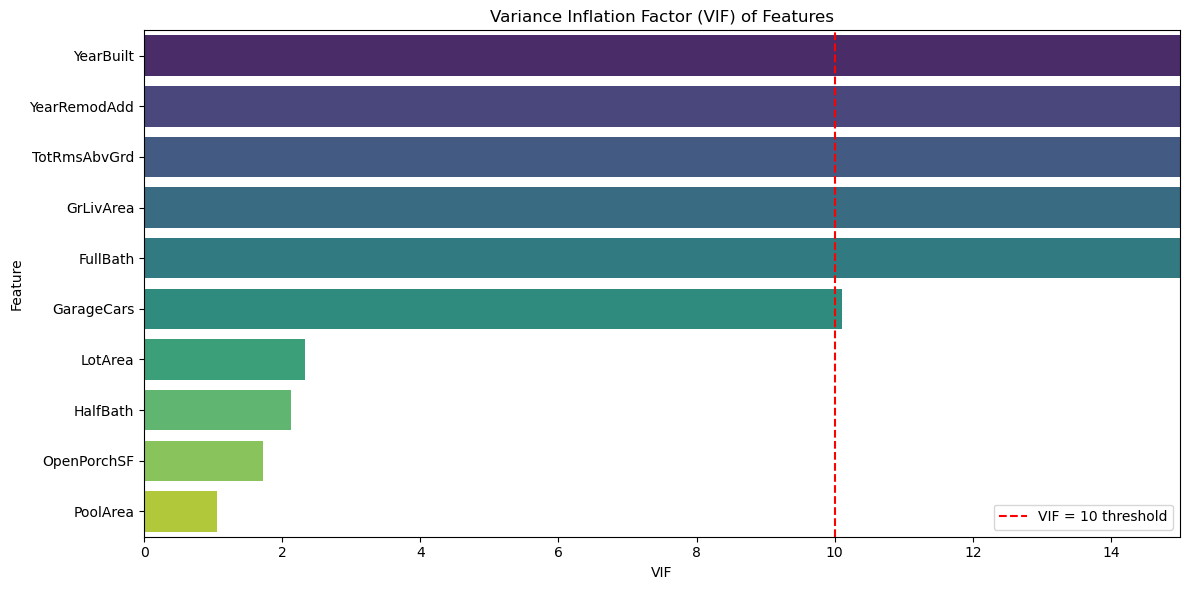

In [12]:
# Sort VIFs descending for better visualization
vif_sorted = vif_df.sort_values("VIF", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="VIF", y="feature", data=vif_sorted, palette="viridis")
plt.axvline(10, color='red', linestyle='--', label='VIF = 10 threshold')
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.title("Variance Inflation Factor (VIF) of Features")
plt.xlim(0, 15)  # Set x-axis scale from 0 to 15
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Chi-square test for categorical variables
chi2_results = []

for var1, var2 in combinations(categorical_cols, 2):
    table = pd.crosstab(reduced_df[var1], reduced_df[var2])
    chi2, p, dof, _ = chi2_contingency(table)
    chi2_results.append({
        'Variable 1': var1,
        'Variable 2': var2,
        'Chi2': chi2,
        'p-value': p
    })

chi2_df = pd.DataFrame(chi2_results).sort_values('p-value')

print("\nChi-Square Test Results (categorical predictors):")
print(chi2_df.to_markdown(index=False))


Chi-Square Test Results (categorical predictors):
| Variable 1   | Variable 2   |      Chi2 |      p-value |
|:-------------|:-------------|----------:|-------------:|
| Neighborhood | HouseStyle   | 1047.26   | 5.59656e-127 |
| Heating      | CentralAir   |  314.83   | 6.4817e-66   |
| Neighborhood | CentralAir   |  237.084  | 5.90334e-37  |
| HouseStyle   | Heating      |  180.295  | 1.81955e-21  |
| HouseStyle   | CentralAir   |   86.3752 | 6.85415e-16  |
| Neighborhood | Heating      |  141.109  | 0.0913586    |


Here, numeric predictors >10 indicate multicollinarity. Therefore, we can drop some of the columns.


Housing Style and Neighborhood -> Chi-square test showed a very strong association, indicating "multicollinearity"
By dropping HouseStyle and keeping Neighborhood, we remove this redundancy.
Heating vs CentralAir ->Strong association only Heating (as Iowa is a cold state) avoids multicollinearity.


In [14]:
reduced_cols = [
    'LotArea',
    'YearBuilt',
    'GrLivArea',
    'FullBath',
    'HalfBath',
    'OpenPorchSF',
    'PoolArea',
    'Neighborhood',
    'Heating',
    'SalePrice'
]

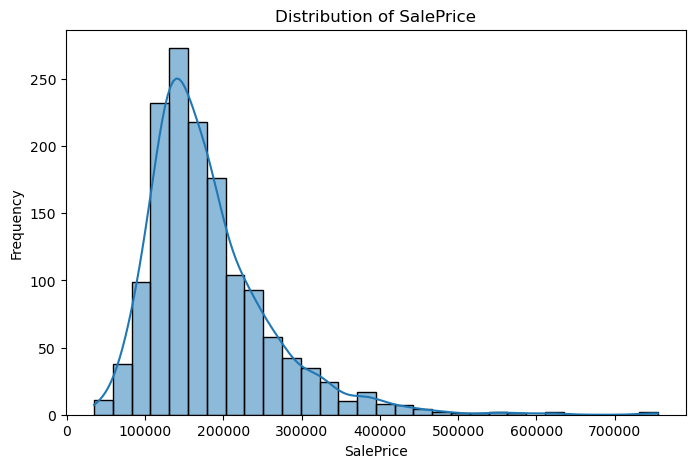

In [15]:
# Check some distributions
# SalesPrice distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.histplot(reduced_df['SalePrice'], bins=30, kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()


In [16]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(reduced_df[reduced_cols], test_size=0.2, random_state=42)
print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")

Training set size: (1168, 10)
Validation set size: (292, 10)


In [17]:
# Run GLM model
import statsmodels.api as sm
import statsmodels.formula.api as smf
formula = 'SalePrice ~ LotArea + YearBuilt + GrLivArea + FullBath + HalfBath + OpenPorchSF + PoolArea + C(Neighborhood) + C(Heating)'
glm_model = smf.glm(formula=formula, data=train_df, family=sm.families.Gaussian()).fit()
print(glm_model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1168
Model:                            GLM   Df Residuals:                     1131
Model Family:                Gaussian   Df Model:                           36
Link Function:               Identity   Scale:                      1.4771e+09
Method:                          IRLS   Log-Likelihood:                -13969.
Date:                Wed, 17 Dec 2025   Deviance:                   1.6706e+12
Time:                        13:08:01   Pearson chi2:                 1.67e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9536
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [18]:
# Create a DataFrame with the model statistics: Deviance, Null Deviance, Deviance Explained, Log_likelihood, AIC
model_stats = {
    'Deviance': round(glm_model.deviance,2),
    'Null Deviance': round(glm_model.null_deviance,2),
    'Deviance Explained': (glm_model.null_deviance - glm_model.deviance) / glm_model.null_deviance,
    'Log-Likelihood': round(glm_model.llf,2),
    'AIC': round(glm_model.aic,2)
}
print(model_stats)

{'Deviance': np.float64(1670569103528.05), 'Null Deviance': np.float64(6966594843571.94), 'Deviance Explained': np.float64(0.7602029196416557), 'Log-Likelihood': np.float64(-13968.7), 'AIC': np.float64(28011.41)}


In [19]:
# Create a df with predictor coefficients, std errors, z-values, p-values, conf intervals
coeff_summary = glm_model.summary2().tables[1]
print("\nGLM Coefficients Summary:")
print(coeff_summary)


GLM Coefficients Summary:
                                   Coef.       Std.Err.          z  \
Intercept                  -1.481075e+06  168435.296137  -8.793137   
C(Neighborhood)[T.Blueste] -3.044383e+04   39886.865665  -0.763254   
C(Neighborhood)[T.BrDale]  -3.834704e+04   15158.101587  -2.529805   
C(Neighborhood)[T.BrkSide] -1.999003e+03   12969.369210  -0.154133   
C(Neighborhood)[T.ClearCr]  6.357771e+03   14128.247199   0.450004   
C(Neighborhood)[T.CollgCr]  4.474545e+03   10670.477518   0.419339   
C(Neighborhood)[T.Crawfor]  3.384578e+04   12653.798902   2.674752   
C(Neighborhood)[T.Edwards] -2.739170e+04   11492.860922  -2.383367   
C(Neighborhood)[T.Gilbert] -9.300358e+03   11261.796494  -0.825833   
C(Neighborhood)[T.IDOTRR]  -1.426860e+04   13971.777382  -1.021245   
C(Neighborhood)[T.MeadowV] -4.533908e+04   16058.459342  -2.823377   
C(Neighborhood)[T.Mitchel] -1.694397e+04   11902.709448  -1.423539   
C(Neighborhood)[T.NAmes]   -9.425165e+03   11115.670015  -0.847

In [20]:
# Remove pool area from model and rerun
import statsmodels.api as sm
import statsmodels.formula.api as smf
formula = 'SalePrice ~ LotArea + YearBuilt + GrLivArea + FullBath + HalfBath + OpenPorchSF + C(Neighborhood) + C(Heating)'
glm_model = smf.glm(formula=formula, data=train_df, family=sm.families.Gaussian()).fit()
print(glm_model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1168
Model:                            GLM   Df Residuals:                     1132
Model Family:                Gaussian   Df Model:                           35
Link Function:               Identity   Scale:                      1.4758e+09
Method:                          IRLS   Log-Likelihood:                -13969.
Date:                Wed, 17 Dec 2025   Deviance:                   1.6706e+12
Time:                        13:08:02   Pearson chi2:                 1.67e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9537
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [21]:
# Remove heating as the entire variable has no significant p-values
# Remove pool area from model and rerun
import statsmodels.api as sm
import statsmodels.formula.api as smf
formula = 'SalePrice ~ LotArea + YearBuilt + GrLivArea + FullBath + HalfBath + OpenPorchSF + C(Neighborhood)'
glm_model = smf.glm(formula=formula, data=train_df, family=sm.families.Gaussian()).fit()
print(glm_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1168
Model:                            GLM   Df Residuals:                     1137
Model Family:                Gaussian   Df Model:                           30
Link Function:               Identity   Scale:                      1.4754e+09
Method:                          IRLS   Log-Likelihood:                -13971.
Date:                Wed, 17 Dec 2025   Deviance:                   1.6775e+12
Time:                        13:08:02   Pearson chi2:                 1.68e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9536
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [22]:
# check results on validation set
val_pred = glm_model.predict(val_df)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_true = val_df['SalePrice']
y_pred = val_pred

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R²:", r2)


Validation RMSE: 41136.21395838259
Validation MAE: 25788.234028036615
Validation R²: 0.7793851195997057


In [23]:
# Print AIC
print("Model AIC:", glm_model.aic)

Model AIC: 28004.236386935525


The model is performing well on the validation set.
It predicts general trends in housing prices accurately, but:
High-priced or unusual homes may still be under- or over-predicted (as indicated by RMSE > MAE).
Some overfitting exists (training R² 0.946 → validation R² 0.788).

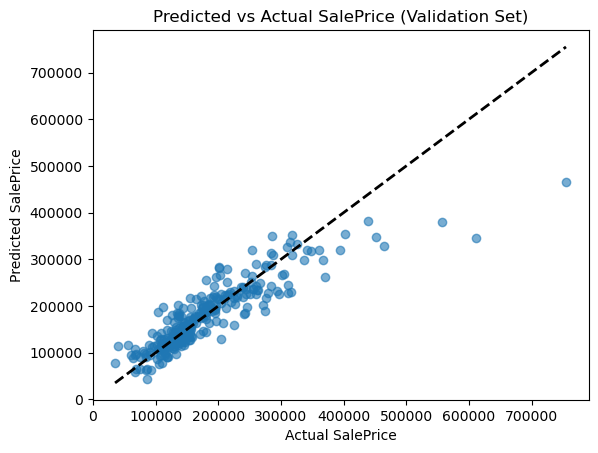

In [24]:
import matplotlib.pyplot as plt

plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs Actual SalePrice (Validation Set)")
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'k--', lw=2)  # reference line
plt.show()


Model predicts moderately priced homes well.
Underestimates high-priced homes, which inflates RMSE relative to MAE. To hopefully be able to estimate homes with high prices better, we will take a look at what happens when we log transform sales prices

In [25]:
import numpy as np

# Apply log transformation
train_df['log_SalePrice'] = np.log(train_df['SalePrice'])
val_df['log_SalePrice'] = np.log(val_df['SalePrice'])


In [26]:
formula_log = """
log_SalePrice ~ LotArea + YearBuilt + GrLivArea + FullBath + HalfBath
                 + C(Neighborhood)
"""

In [27]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

glm_log = smf.glm(
    formula=formula_log,
    data=train_df,
    family=sm.families.Gaussian()
).fit()

print(glm_log.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          log_SalePrice   No. Observations:                 1168
Model:                            GLM   Df Residuals:                     1138
Model Family:                Gaussian   Df Model:                           29
Link Function:               Identity   Scale:                        0.034340
Method:                          IRLS   Log-Likelihood:                 326.80
Date:                Wed, 17 Dec 2025   Deviance:                       39.079
Time:                        13:08:02   Pearson chi2:                     39.1
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9687
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [28]:
# Predict log(SalePrice) on validation
val_pred_log = glm_log.predict(val_df)

# Back-transform to original SalePrice scale
val_pred = np.exp(val_pred_log)


In [29]:
glm_log = smf.glm(
    formula=formula_log,
    data=val_df,
    family=sm.families.Gaussian()
).fit()

print(glm_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          log_SalePrice   No. Observations:                  292
Model:                            GLM   Df Residuals:                      262
Model Family:                Gaussian   Df Model:                           29
Link Function:               Identity   Scale:                        0.035102
Method:                          IRLS   Log-Likelihood:                 90.525
Date:                Wed, 17 Dec 2025   Deviance:                       9.1967
Time:                        13:08:02   Pearson chi2:                     9.20
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9880
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = val_df['SalePrice']
y_pred = val_pred

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R²:", r2)


Validation RMSE: 37500.492377194365
Validation MAE: 24719.638822455054
Validation R²: 0.8166587847053601


The model performs slightly better with log transformed sales prices

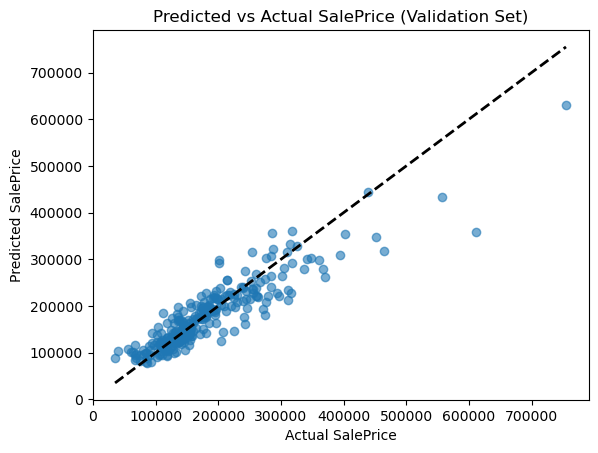

In [31]:
# Plot residuals of model with log transformed Sales Prices
plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs Actual SalePrice (Validation Set)")
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'k--', lw=2)  # reference line
plt.show()


In [32]:
# Print AIC
print("Model AIC:", glm_model.aic)

Model AIC: 28004.236386935525


/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_2102/2142532545.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="feature", data=vif_sorted, palette="viridis")


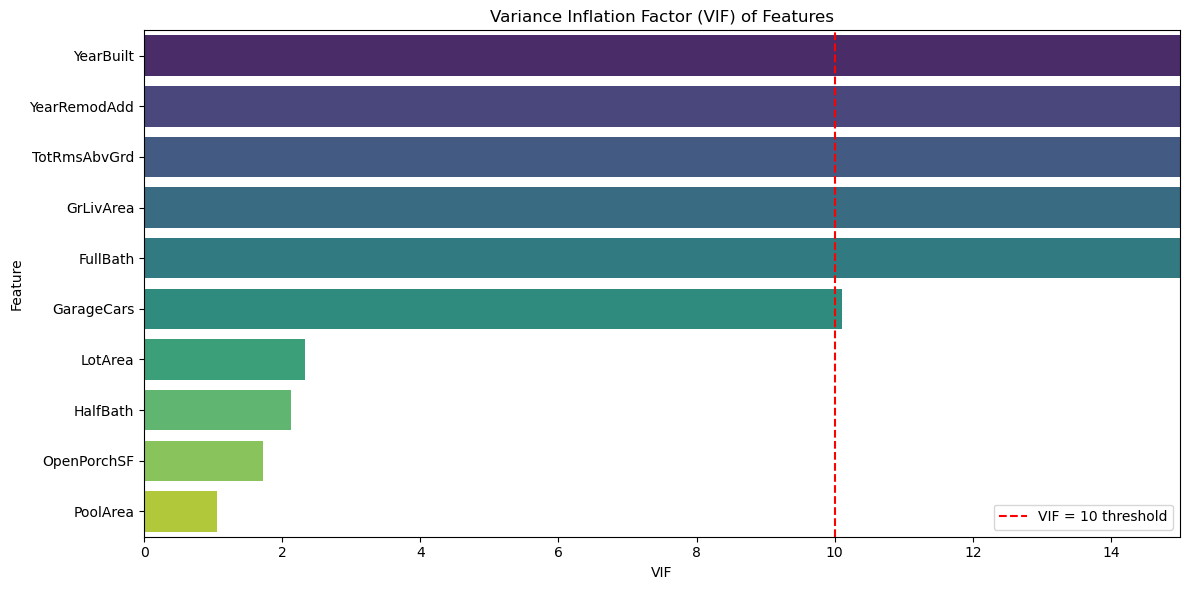

In [33]:
#  Visualize VIFs
# Sort VIFs descending for better visualization
vif_sorted = vif_df.sort_values("VIF", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="VIF", y="feature", data=vif_sorted, palette="viridis")
plt.axvline(10, color='red', linestyle='--', label='VIF = 10 threshold')
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.title("Variance Inflation Factor (VIF) of Features")
plt.xlim(0, 15)  # Set x-axis scale from 0 to 15
plt.legend()
plt.tight_layout()
plt.show()


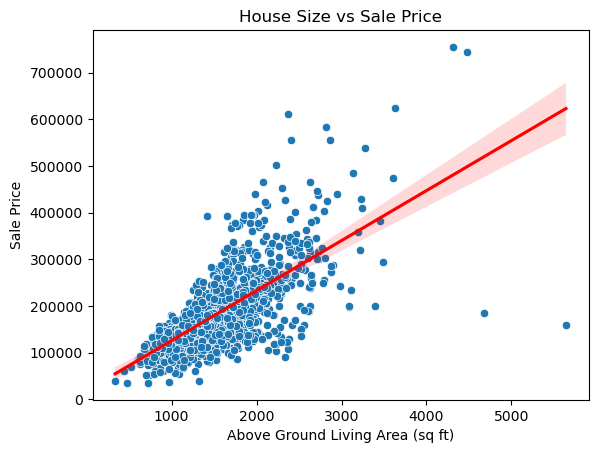

In [34]:
# Vizualize sales price vs living area
sns.scatterplot(x='GrLivArea', y='SalePrice', data=data)
sns.regplot(x='GrLivArea', y='SalePrice', data=data, scatter=False, color='red')
plt.title('House Size vs Sale Price')
plt.xlabel('Above Ground Living Area (sq ft)')
plt.ylabel('Sale Price')
plt.show()

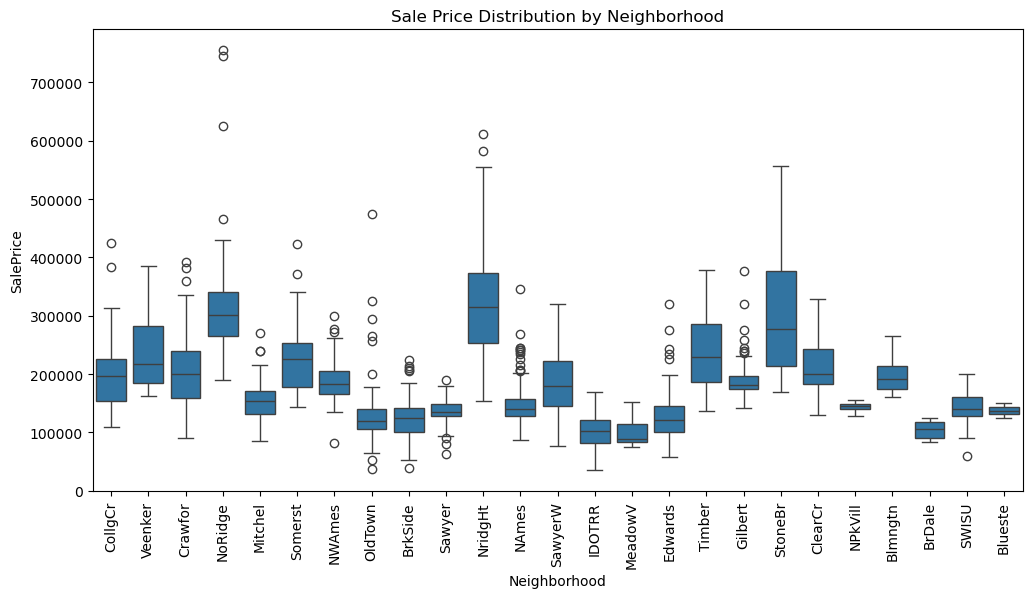

In [35]:
# Visualize sales price by neighborhood
plt.figure(figsize=(12,6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=data)
plt.xticks(rotation=90)
plt.title('Sale Price Distribution by Neighborhood')
plt.show()

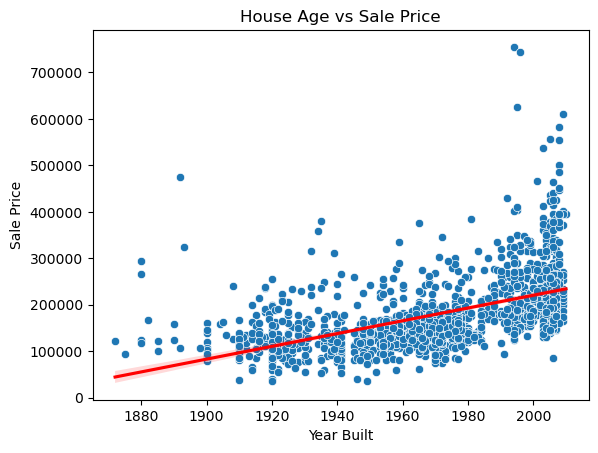

In [36]:
# Visualize House Price vs Year Built
sns.scatterplot(x='YearBuilt', y='SalePrice', data=data)
sns.regplot(x='YearBuilt', y='SalePrice', data=data, scatter=False, color='red')
plt.title('House Age vs Sale Price')
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.show()

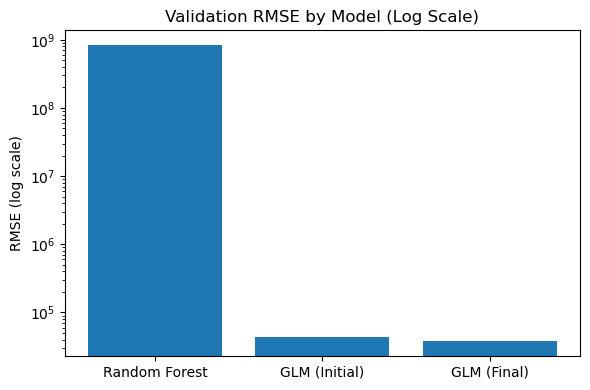

In [37]:
# Visualizing model comparison:
import matplotlib.pyplot as plt

models = ['Random Forest', 'GLM (Initial)', 'GLM (Final)']
rmse = [834463000.78, 42935.4, 37500.5]

plt.figure(figsize=(6,4))
plt.bar(models, rmse)
plt.yscale('log')
plt.title('Validation RMSE by Model (Log Scale)')
plt.ylabel('RMSE (log scale)')
plt.tight_layout()
plt.show()



In [38]:
import pandas as pd

data = {
    "Model": [
        "Model 1 (Random Forest)",
        "Model 2 (GLM)",
        "Final Model (GLM)"
    ],
    "AIC": [
        None,
        27619.86,
        24554.73
    ],
    "Validation RMSE": [
        834463000.78,
        42935.4,
        37500.5
    ],
    "Validation R²": [
        0.89,
        0.76,
        0.82
    ]
}

df = pd.DataFrame(data)
print(df.to_markdown(index=False))

| Model                   |     AIC |   Validation RMSE |   Validation R² |
|:------------------------|--------:|------------------:|----------------:|
| Model 1 (Random Forest) |   nan   |       8.34463e+08 |            0.89 |
| Model 2 (GLM)           | 27619.9 |   42935.4         |            0.76 |
| Final Model (GLM)       | 24554.7 |   37500.5         |            0.82 |


The model still struggles to predict prices for higher priced houses, but performs slightly better